# Imports

In [1]:
!pip install tensorflow-datasets

     |████████████████████████████████| 3.9 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 9.3 MB/s  eta 0:00:01
     |████████████████████████████████| 829 kB 12.0 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 5.8 MB/s  eta 0:00:01
     |████████████████████████████████| 47 kB 8.4 MB/s  eta 0:00:01
     |████████████████████████████████| 198 kB 12.0 MB/s eta 0:00:01
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491059 sha256=feca51a42d6d58dd25e56db59a0d8db325b3e31a953b9b8d5d2ca4cf0b7798e8
  Stored in directory: /root/.cache/pip/wheels/6e/9c/ed/4499c9865ac1002697793e0ae05ba6be33553d098f3347fb94
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21494 sha256=6e7a8f37386fcf942a11fa8abf40ae408bfa4d01f74b7b2f7da5ca9a8f131e8e
  Stored in directory: /root/.cache/pip/wheels/59/9a/1d/3f1afbbb5122d0410547bf9eb50955f4a7a98e53a6d8b99bd1
Successfully built future promise
You should consider upgrading via the '/

In [31]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf 

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

# Graphs

In [32]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

# Input Pipeline

In [33]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

print(train_dataset.element_spec)

for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))
text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [34]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64

In [36]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [37]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

text:  [b'Though this movie is cheesiness at its best, it is pulled off perfectly. This movie, without a doubt, has to be considered a modern classic. There are basically two kinds of movies I like - movies with depth (chick flicks, if you must - I blame my wife for this) and mindless comedies where I can sit back and relax. This movie is a perfect example of the latter.<br /><br />A friend of mine turned me on to this movie shortly after its release. Considering me to somewhat shallow, he said to me, "You\'ve got to see this movie. It\'s just your type of movie." Foregoing the insult, I started watching. I know they mentioned The Ramones a million times, but when you actually see them, I said, "Hey, it is The Ramones." My friend replied, "I don\'t know they were a real band." I had my moment of glory.<br /><br />This movie, though now somewhat dated, is a must see for Ramones fans - or anyone else for that matter.'
 b"Mimicking its long title the movie finds ways to come close to the 

#  Create the text encoder

In [38]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [39]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [58]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

43328

# Model

In [45]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [46]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer=tf.keras.optimizers.Adam(1e-4),
             metrics=['accuracy'])

# Train

In [47]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
TF_FORCE_GPU_ALLOW_GROWTH=1
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [48]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [54]:
history = model.fit(train_dataset, epochs=10,
                   validation_data=test_dataset,
                   validation_steps=30)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: ', test_loss)
print('Test Accuracy: ',test_acc)

391/391 [==============================] - 13s 34ms/step - loss: 0.3270 - accuracy: 0.8615
Test Loss:  0.32699447870254517
Test Accuracy:  0.861519992351532


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          64000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________


(0.0, 0.6571881800889969)

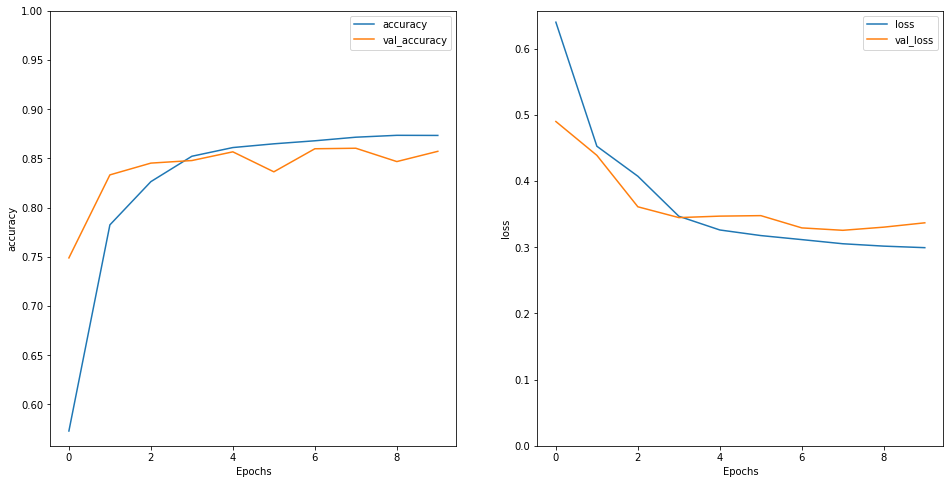

In [24]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

# Prediction 

In [25]:
sample_text= ('The movie was horrible. The animation and the graphics '
               'were really bad. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
predictions

array([[-2.682914]], dtype=float32)

In [26]:
type(sample_text)

str

In [27]:
if(predictions>0.0):
    print('positive')
else:
    print('negative')

negative


In [28]:
model.save('model/')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [27]:
model_json = model.to_json()
with open('model.json', 'w') as js:
    js.write(model_json)
model.save_weights('model', save_format='tf')